## Análisis Animales Cuenta Zoológico Nacional de la República Dominicana ##

Debido al asombroso manejo que ha venido teniendo esta institución en sus cuentas de redes sociales, creemos que es de interés tratar de encontrar cuales animales tienen mayor frecuencia de exposición y cuales generan mayor interés.

Usaremos una lista de especies extraída del website del ZooDom.
Luego extraeremos una cierta cantidad de publicaciones de su cuenta de Instagram y utilizaremos un algoritmo para extraer las especies presentes en cada publicación, luego medir las interacciones promedio de cada especie y hacer un ranking de frecuencia e interés.

In [3]:
# Librerias a ser usadas durante el análisis
import requests as rs
import pandas as pd
import regex
import re
import emoji
import matplotlib.pyplot as plt
import numpy as np
from unidecode import unidecode as uni

In [4]:
# Variables iniciales
table = []
token = "EAADhbHEHmlABAGwSGI1mpq5XCCwFtg3Not5QYB7EisDw9qw21jzI3UZCRtQ0jkbfE231BFyTPc5XEUeOMHQ9IkhaK4buUjb74Yw8xwAqZArczRZCdZB4ME1G7R1ZAsKZBqAZC2KzgDo1NL0DCUAC886hIZBk1tUQJg8H0bicZC36dDQZDZD"
username = ["zoodomrd"]
numeroPosts = 500

Aquí procedemos a crear las listas de especies. Crearemos una lista de especies por clase de animal, usando cuatro clases de vertebrados terrestres:

**Aves, Mamíferos, Reptiles y Anfibios**

La razón es porque también queremos descubrir cual clase de animales impacta más. Como hipótesis, creemos que los mamíferos serán esa clase, pues son más cercanos a nosotros y generan mayor nivel de empatía.

Para poder minimizar las diferencias, usaremos un metodo para eliminar las tildes o acentos diacríticos. Suponemos que dentro de tantas publicaciones, es posible que haya ligeros errores de escritura con las tildes.

In [5]:
# Lista de elementos
aves = ['Aura', 'Avestruz', 'Buitre', 'Cacatúa', 'Casuario', 'Cigua', 'Cigüeña', 'Cisne', 'Cotorra', 'Cucú', 'Cuervo', 'Cuyaya', 'Emú', 'Faisan', 'Flamenco', 'Gallareta', 'Gallina', 'Grulla', 'Guacamayo', 'Guaraguao', 'Guinea', 'Lechuza', 'Loris', 'Loro', 'Marabú', 'Mutón', 'Paloma', 'Pato', 'Pavo', 'Pelícano','Perdiz', 'Perico', 'Rolón', 'Tucán', 'Tórtola', 'Yaguaza']
for a in range(len(aves)):
    temp = uni(aves[a])
    aves[a] = temp

mammal = ['Ankole', 'Antílope', 'Bisonte', 'Buck', 'Bufalo', 'Burro', 'Búfalo', 'Cabra', 'Camello',
          'Capibara', 'Cebra', 'Cebú', 'Cebú', 'Chimpacé', 'Chimpancé', 'Cobayo', 'Conejo', 'Dromedario',
          'Eland', 'Ferret', 'Gamo', 'Guenón', 'Hiena', 'Hipopótamo', 'Hutía', 'Jaguar', 'León', 
          'Lémur', 'Mapache', 'Mono', 'Muflón', 'Nilgai', 'Nilghai', 'Ocelote', 'Oveja', 'Poni', 'Pony',
          'Pony', 'Rinoceronte', 'Solenodón', 'Taurotragus', 'Tigre', 'Vaca', 'Venado', 'Venado', 'Wallabi',
          'Zorrillo']
for a in range(len(mammal)):
    temp = uni(mammal[a])
    mammal[a] = temp

reptil = ['Anaconda', 'Boa', 'Cocodrilo', 'Coral', 'Escinco', 'Hicotea', 'Iguana', 'Lagarto', 'Pitón', 'Serpiente', 'Tegu', 'Tortuga']
for a in range(len(reptil)):
    temp = uni(reptil[a])
    reptil[a] = temp

anfibio = ['Calcalí', 'Rana']
for a in range(len(anfibio)):
    temp = uni(anfibio[a])
    anfibio[a] = temp

animales = aves + mammal  + anfibio + reptil
animales.sort()

Aquí tenemos el método para extraer la información de la cuenta usando la plataforma **Instagram Graph API**. Crearemos un DataFrame con la información de las publicaciones escogidas. Salvaremos el extracto en un archivo csv para posterior re-uso sin tener que hacer nuevas peticiones al servidor de Instagram.

In [ ]:
# Extract posts data

data = []

for a in range(len(username)):
    url = ("https://graph.facebook.com/v3.2/17841401726234706"
        "?fields=business_discovery.username("+username[a]+"){media.limit("+str(numeroPosts)+")"
        "{username,timestamp,media_type,caption,media_url,like_count,comments_count,permalink,id}}"
        "&access_token="+token)
    info = rs.get(url)
    table = info.json()
    data.extend(table["business_discovery"]["media"]["data"])
            
profileMedia = pd.DataFrame(data, columns=data[0].keys())
profileMedia["timestamp"] = pd.to_datetime(profileMedia["timestamp"])
colu = []
for key in profileMedia.keys():
    colu.append(key)
colu[8] = "post_id"
    
profileMedia.columns = colu
profileMedia.to_csv(r'.\profile_media.csv')

En este paso, haremos la clasificación de cada publicación, asignándole una especie y una clase a cada uno. Como la cuenta generalmente utiliza un pie de página para informar de que especie se trata, primero veremos si la publicación contiene ese pie de página, lo que nos asegurará que estamos asignando la especie correcta.

De no existir este pie de página, escanearemos el texto completo de la publicación para confirmar si alguna especie fue mencionada. Este método es menos preciso, pues en un mismo texto puede mencionarse más de una especie y no podremos identificar cual es la especie central.

Luego de asignada cada especie, procederemos a asignar cada clase, y entonces crear en el DataFrame dos columnas nuevas con esa información. Después de eso, extraeremos del DataFrame las publicaciones que no contengan especies definidas. Normalmente son publicaciones que se enfocan en humanos o en acciones institucionales, y que no nos sirven para nuestro análisis.

In [6]:
profileMedia = pd.read_csv("profile_media.csv")
profileMedia["engagements"] = profileMedia["like_count"]+profileMedia["comments_count"]
# Classify by animal
animal = []
tipo = []
a = 0
captions = profileMedia["caption"][0:500]
for row in captions:
    a+=1
    temp = ""
    try:
        if "Especie" in row:
            especie = row.split("Especie")[1]
    except:
        especie = ""
        for ani in animales:
            if ani.lower() in uni(especie.lower()):
                temp = ani
    else:
        for ani in animales:
            if ani.lower() in uni(row.lower()):
                temp = ani
    animal.append(temp)

for ani in animal:
    if ani in aves:
        tipo.append("Ave")
    elif ani in mammal:
        tipo.append("Mamífero")
    elif ani in reptil:
        tipo.append("Reptil")
    elif ani in anfibio:
        tipo.append("Anfíbio")
    else:
        tipo.append("")
        
last500 = profileMedia[0:500].copy()
last500["especie"] = animal
last500["clase"] = tipo

animal_list = {}
for f in animal:
    if f not in animal_list:
        animal_list[f] = 1
    else:
        animal_list[f] += 1
        
true_last = last500[last500["especie"] != ""]

likes = true_last["like_count"]
coms = true_last["comments_count"]
engage = likes + coms

Luego usaremos un algoritmo para extraer las palabras de cada publicación, asignarlas a un nuevo DataFrame con la información de cada publicación adjunta, así como un enlace del Post ID. Con esto podremos identificar las palabras más frecuentes y más relevantes.

Haremos lo propio con los emojis de cada publicación.

In [17]:
#extract all words from posts
postWords = []
wordLikes = []
wordCom = []
wordpostID = []
wordEngage = []


for a in range(len(profileMedia)):
    try:
        sepaTemp = re.findall("\s*([$#%\w-]+)",profileMedia["caption"][a])
    except:
        sepaTemp = ""
    for b in range(len(sepaTemp)):
        postWords.append(sepaTemp[b])
        wordLikes.append(profileMedia["like_count"][a])
        wordCom.append(profileMedia["comments_count"][a])
        wordEngage.append(profileMedia["like_count"][a]+profileMedia["comments_count"][a])
        wordpostID.append(profileMedia["post_id"][a])


postWordList = pd.DataFrame([postWords, wordLikes, wordCom, wordEngage, wordpostID], ["palabras", "likes", "comments", "engagements", "post_id"])
postWordList = pd.DataFrame.transpose(postWordList)


# Fucntion to extract emojis
def split_count(text):

    emoji_list = []
#     flags = regex.findall(u'[\U0001F1E6-\U0001F1FF]', text) 
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

# Extract emojis from posts
postEmoji = []
emojiUser = []
emojiEngage = []
emojipostID = []

for a in range(len(profileMedia)):
    try:
        temp = split_count(profileMedia["caption"][a])
        for b in temp:
            postEmoji.append(b)
            emojiEngage.append(profileMedia["like_count"][a]+profileMedia["comments_count"][a])
            emojiUser.append(profileMedia["username"][a])
            emojipostID.append(profileMedia["post_id"][a])
    except:
        pass

postEmojiList = pd.DataFrame([emojiUser, postEmoji, emojiEngage, emojipostID], ["username", "emoji", "engagements", "post_id"])
postEmojiList = pd.DataFrame.transpose(postEmojiList)

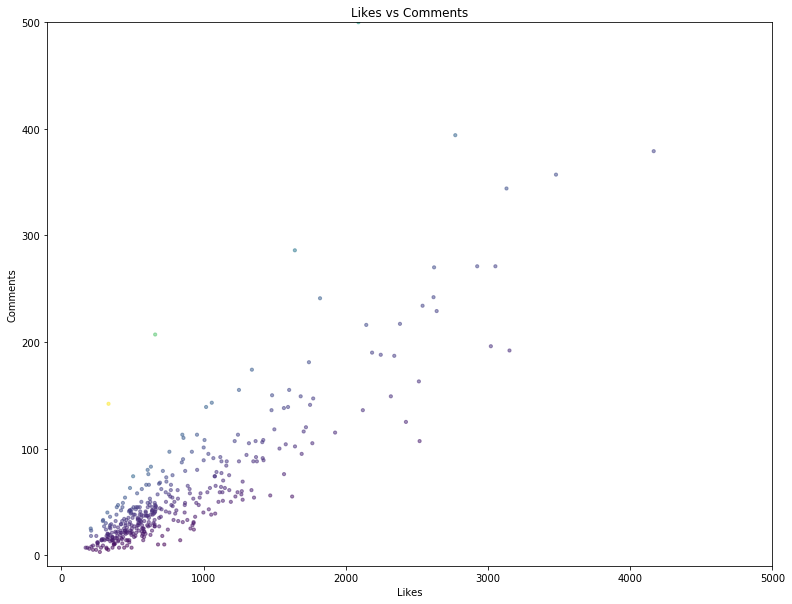

In [7]:
fig, ax = plt.subplots()
fig.set_size_inches(13,10)

ax.set_xlabel("Likes")
ax.set_ylabel("Comments")
ax.set_title("Likes vs Comments")

ax.scatter(likes, coms, s=10, alpha=0.5, c=coms/likes)
plt.ylim(-10,500)
plt.xlim(-100,5000)
plt.show()


Procedemos a encontrar las 20 especies más frecuentes.

In [8]:
round(true_last["especie"].value_counts(normalize=True)*100, 2)[0:20]

Leon           8.59
Rana           7.03
Flamenco       5.73
Tigre          5.47
Cocodrilo      4.95
Jaguar         4.95
Mono           3.91
Rinoceronte    3.91
Hipopotamo     3.91
Lemur          3.91
Vaca           3.65
Pato           2.86
Lechuza        2.34
Emu            2.34
Dromedario     2.08
Tortuga        2.08
Bisonte        1.82
Cebra          1.82
Cacatua        1.82
Avestruz       1.82
Name: especie, dtype: float64

In [9]:
species_amount = true_last["especie"].value_counts()[0:20]

In [10]:
top_20_species = (true_last["especie"].value_counts(normalize=True)*100)[0:20].index

In [11]:
top_20_species

Index(['Leon', 'Rana', 'Flamenco', 'Tigre', 'Cocodrilo', 'Jaguar', 'Mono',
       'Rinoceronte', 'Hipopotamo', 'Lemur', 'Vaca', 'Pato', 'Lechuza', 'Emu',
       'Dromedario', 'Tortuga', 'Bisonte', 'Cebra', 'Cacatua', 'Avestruz'],
      dtype='object')

In [13]:
top_species_engage = []
for a in top_20_species:
    mean = true_last[true_last["especie"] == a]["engagements"].mean()
    top_species_engage.append(round(mean,2))
    
top_species_coms = []
for a in top_20_species:
    mean = true_last[true_last["especie"] == a]["comments_count"].mean()
    top_species_coms.append(round(mean,2))
    
top_species_likes = []
for a in top_20_species:
    mean = true_last[true_last["especie"] == a]["like_count"].mean()
    top_species_likes.append(round(mean,2))

top_species_weight = []
for a in top_20_species:
    impact = true_last[true_last["especie"] == a]["engagements"].mean()+pow(species_amount[a],2)
    top_species_weight.append(round(impact,2))
 

    
tops = pd.DataFrame([top_20_species, species_amount, top_species_likes, top_species_coms, top_species_engage, top_species_weight], ["especies", "posts", "avg_likes", "avg_comments", "avg_engagements", "avg_weight"])
tops = pd.DataFrame.transpose(tops)


In [14]:
tops

,especies,posts,avg_likes,avg_comments,avg_engagements,avg_weight
0,Leon,33,1983.91,211.55,2195.45,3284.45
1,Rana,27,790.44,58.26,848.7,1577.7
2,Flamenco,22,677.55,34.95,712.5,1196.5
3,Tigre,21,1464.38,147.48,1611.86,2052.86
4,Cocodrilo,19,852.84,71.26,924.11,1285.11
5,Jaguar,19,1201.63,79.37,1281,1642
6,Mono,15,852.07,62.07,914.13,1139.13
7,Rinoceronte,15,768.6,42.6,811.2,1036.2
8,Hipopotamo,15,1181.33,89,1270.33,1495.33
9,Lemur,15,695.27,45.47,740.73,965.73


Let's graph the top 20 species by Avg. Weight

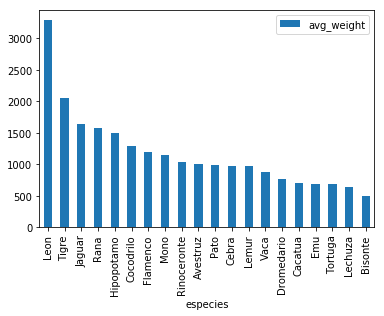

In [47]:
tops.sort_values('avg_weight', ascending=False).plot.bar(x="especies", y="avg_weight", rot=90) 

Aquí salvamos los distintos DataFrames en un archivo de Excel.

In [18]:
writer = pd.ExcelWriter(username[0] + " IG.xlsx", engine = 'xlsxwriter',  options={'remove_timezone': True})
profileMedia.to_excel(writer, sheet_name="IG competition media", index=None, header=True)
postWordList.to_excel(writer, sheet_name="IG competition words", index=None, header=True)
postEmojiList.to_excel(writer, sheet_name="IG competition emoji", index=None, header=True)
true_last.to_excel(writer, sheet_name="Last 500 Processed", index=None, header=True)
tops.to_excel(writer, sheet_name="Top 20 Especies", index=None, header=True)



writer.save()
writer.close()

Final visualization via Tableau

![Especies más relevantes](images/Especies.png)